# Little's Power Law Data Analysis    
In this notebook I will explore answers to questions that have bothered me in my software delivery role. Why I cannot use vanilla Little's Law to predict / forecast when piece of work will be ready, and what can I do to make it useful. 

### Little's Law
$LT=TH*WIP$
where LT is lead time (total time), TH is throughput (cycle time) and WIP is work in progress (commited work in the queue). Assumption that is made under Little's law is that system is stable i.e. mean and variance do not change over time and work cannot halt to be resumed later.  

The problem is that this is not the case with knowledge work, as mean and variance can drastically shift when work "goes long" creating thick tails and work can be halted and resumed later. 

### Data Background
"Sprint Team" anonymised data was kindly provided by one of my employers. Data represents 1 feature team over 1 year period.

## Initial data analysis 

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

sprints = pd.read_csv("sprintTeam.csv")
sprints["CycleTime"] = sprints["CycleTime"]+1
sprints["LeadTime"] = sprints["LeadTime"]+1
display(sprints.head())

,Sprint,CycleTime,LeadTime
0,A,2,5
1,A,4,11
2,A,7,11
3,A,1,11
4,A,5,11


In [58]:
sprints.describe()

,CycleTime,LeadTime
count,516.000000,516.000000
mean,5.449612,9.447674
std,4.315178,4.520415
min,1.000000,2.000000
25%,2.000000,7.000000
50%,4.000000,9.000000
75%,8.000000,11.000000
max,35.000000,40.000000


<AxesSubplot:ylabel='Frequency'>

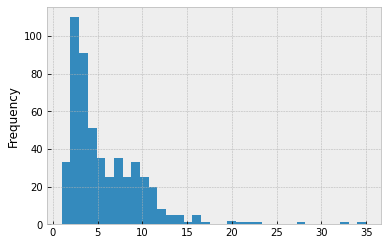

In [59]:
sprints["CycleTime"].plot(kind="hist", bins=35)

<AxesSubplot:ylabel='Frequency'>

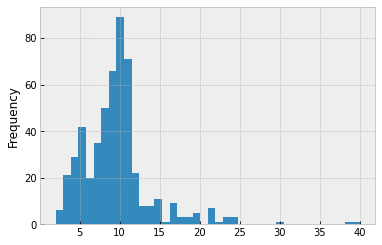

In [60]:
sprints["LeadTime"].plot(kind="hist", bins=40)

In [61]:
sprints_workitem_count = sprints.groupby('Sprint').agg(Count =('Sprint', 'count'))
sprints_workitem_count = sprints_workitem_count.reset_index()
sprints_workitem_count.describe()

,Count
count,26.000000
mean,19.846154
std,6.149421
min,5.000000
25%,16.000000
50%,19.000000
75%,24.000000
max,33.000000


<AxesSubplot:ylabel='Frequency'>

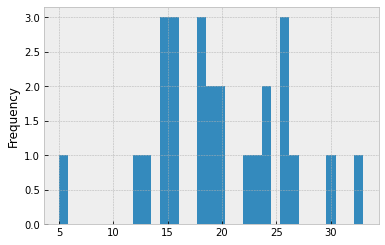

In [62]:
sprints_workitem_count["Count"].plot(kind="hist", bins=33)

## Looking at the log scale of distribution

In [63]:
sprints_log = sprints.copy(deep=True)
sprints_log["CycleTime"] = np.log10(sprints["CycleTime"])
sprints_log["LeadTime"] = np.log10(sprints["LeadTime"])
sprints_log.describe()

,CycleTime,LeadTime
count,516.000000,516.000000
mean,0.620401,0.929256
std,0.320001,0.205776
min,0.000000,0.301030
25%,0.301030,0.845098
50%,0.602060,0.954243
75%,0.903090,1.041393
max,1.544068,1.602060


In [64]:
display(sprints_log.head())

,Sprint,CycleTime,LeadTime
0,A,0.301030,0.698970
1,A,0.602060,1.041393
2,A,0.845098,1.041393
3,A,0.000000,1.041393
4,A,0.698970,1.041393


<AxesSubplot:ylabel='Frequency'>

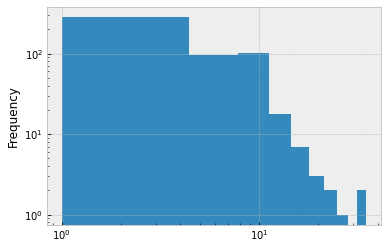

In [65]:
sprints["CycleTime"].plot(kind="hist", logy=True, logx=True)

<AxesSubplot:ylabel='Frequency'>

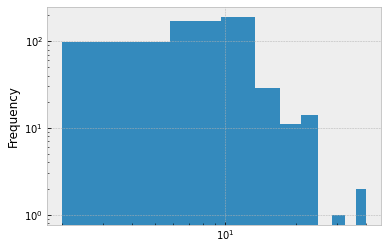

In [66]:
sprints["LeadTime"].plot(kind="hist", logx=True, logy=True)

## Finding distribution

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 36.80it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.643274,1066.674897,-3438.149881,inf,0.137322,5.988130e-09
lognorm,0.648099,1029.108214,-3428.048063,inf,0.112849,3.521478e-06
exponpow,0.666034,1059.180107,-3413.962713,inf,0.168959,2.400026e-13
chi2,0.683279,1192.999674,-3400.772249,inf,0.237677,3.944274e-26
cauchy,0.715876,1077.947455,-3382.971156,inf,0.220051,2.012268e-22


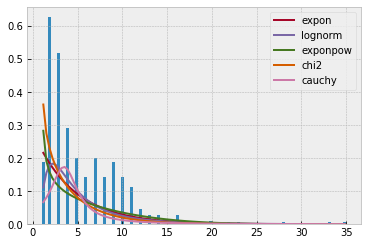

In [67]:

from fitter import Fitter, get_common_distributions, get_distributions

f_cycle = Fitter(sprints["CycleTime"].values, distributions=get_common_distributions())
f_cycle.fit()
f_cycle.summary()

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 40.95it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,0.445269,1025.778265,-3627.982050,inf,0.096007,1.365415e-04
rayleigh,0.463697,1397.760322,-3607.057660,inf,0.170400,1.438633e-13
norm,0.463908,1733.654458,-3606.822156,inf,0.196918,5.232667e-18
lognorm,0.464479,1156.635233,-3599.941800,inf,0.133319,1.852778e-08
gamma,0.465260,1198.585606,-3599.074936,inf,0.140849,2.152095e-09


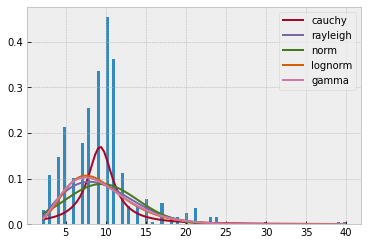

In [68]:
f_lead = Fitter(sprints["LeadTime"].values, distributions=get_common_distributions())
f_lead.fit()
f_lead.summary()

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 58.14it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
chi2,0.884803,731.791214,-78.118371,inf,0.100690,0.930913
lognorm,0.886076,731.360836,-78.080990,inf,0.103799,0.914856
gamma,0.886340,730.839618,-78.073251,inf,0.104779,0.909429
norm,0.886405,728.768307,-81.329425,inf,0.105207,0.907004
exponpow,0.894458,706.550596,-77.836190,inf,0.128244,0.738757


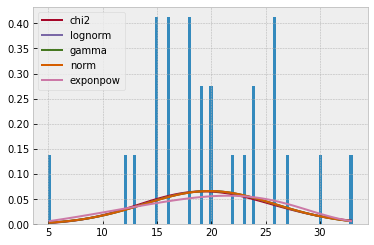

In [69]:
f_wip = Fitter(sprints_workitem_count["Count"].values, distributions=get_common_distributions())
f_wip.fit()
f_wip.summary()

For cycle time and lead time lognormal distributions are choosen as they should not overfit and adjust well as new data is added. 

## Fitting to data

### Cycle Time

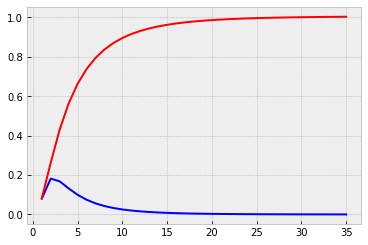

In [179]:
from pylab import linspace
import scipy.stats

cycle_dist = scipy.stats.lognorm
cycle_min = int(sprints.describe().CycleTime["min"])
cycle_max = int(sprints.describe().CycleTime["max"])
X = linspace(cycle_min, cycle_max, cycle_max)
cycle_fitted = cycle_dist.pdf(X, *f_cycle.fitted_param['lognorm'])
cycle_cumulative = np.cumsum(cycle_fitted)
plt.plot(X, cycle_fitted, c='blue')
plt.plot(X, cycle_cumulative, c='red')
plt.show()

35 35


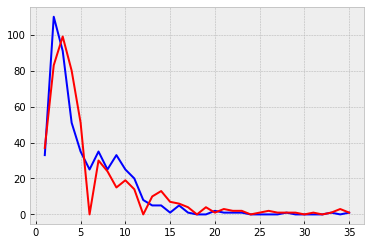

In [210]:
cycle_fitted_discretized = np.copy(cycle_fitted)
p_overflow = (cycle_cumulative[-1:]-1.0)[0]
p_max_index = np.argmax(cycle_fitted)
cycle_fitted_discretized[p_max_index] -= p_overflow

actual, bins = np.histogram(sprints["CycleTime"], bins=cycle_max)
simulated, bins = np.histogram(np.random.choice(X, 516, p=cycle_fitted_discretized), bins=cycle_max)

print(cycle_max, len(cycle_fitted_discretized))

plt.plot(X, actual, c='blue')
plt.plot(X, simulated, c='red')
plt.show()

### Lead Time

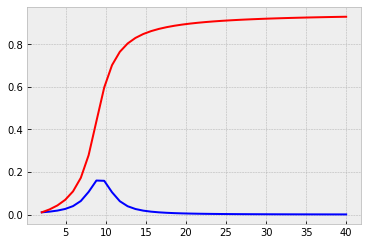

In [242]:
lead_dist = scipy.stats.cauchy
lead_min = int(sprints.describe().LeadTime["min"])
lead_max = int(sprints.describe().LeadTime["max"])
X = linspace(lead_min, lead_max, lead_max)
lead_fitted = lead_dist.pdf(X, *f_lead.fitted_param['cauchy'])
lead_cumulative = np.cumsum(lead_fitted)
plt.plot(X, lead_fitted, c='blue')
plt.plot(X, lead_cumulative, c='red')
plt.show()

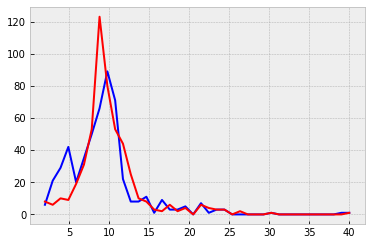

In [282]:
lead_fitted_discretized = np.copy(lead_fitted)
p_overflow = (lead_cumulative[-1:]-1.0)[0]
p_max_index = np.argmax(lead_fitted)
lead_fitted_discretized[p_max_index] -= p_overflow

actual, bins = np.histogram(sprints["LeadTime"], bins=lead_max)
simulated, bins = np.histogram(np.random.choice(X, 516, p=lead_fitted_discretized), bins=lead_max)

plt.plot(X, actual, c='blue')
plt.plot(X, simulated, c='red')
plt.show()